# Geting the exit and entry points to the clutter and save the csv file

#### Here there the trajectory will be divided into the "in-mid-out" and "out-mid-in" section. Then select only 'mid' part. Then get the average of the 'mid' section to get exit/entry points

In [99]:
import os
import pandas as pd
import numpy as np
import math

# matplot
import matplotlib.pyplot as plt

# Config
import configparser

from navipy.tools.plots import get_color_dataframe

In [51]:
# We read the config
config = configparser.ConfigParser()
config.read(['defaultconfig.ini', 'config.ini']);
rootfoldercalib = config['Path']['path2calibrations']
rootfolderdata = config['Path']['path2recordings']
conditions_fname = config['Path']['path2conditions']
obj_file = config['Path']['template2objects']

In [395]:
# bee id and recording
bee_id = '85B'
recording = '20210416_173327'

In [396]:
# get trajectory csv file ---- traj_nv
common_path = '/path/'
recording_path = os.path.join(common_path,bee_id,'{}_test'.format(recording))
traj_nv = pd.read_csv(os.path.join(recording_path,('traj_data_{}_test.csv'.format(recording))))

In [397]:
traj_nv.head()


,Unnamed: 0,frame_i,x,y,z,w,bee_distance,timeseries
0,0,1185,-0.427904,-0.320820,0.412456,6.465529e-16,0.534815,0.000
1,1,1187,-0.405499,-0.346184,0.432729,6.790853e-16,0.533173,0.016
2,2,1189,-0.381641,-0.364630,0.449624,7.019748e-16,0.527830,0.032
3,3,1190,-0.370286,-0.372709,0.458288,7.119075e-16,0.525380,0.048
4,4,1191,-0.356233,-0.377407,0.465324,7.169269e-16,0.518978,0.064


In [ ]:
recording_path

Text(0, 0.5, 'x OR y')

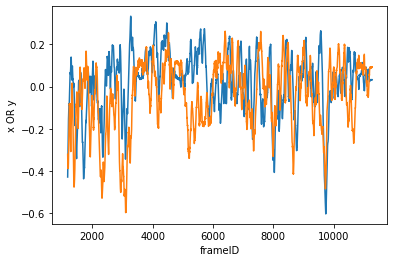

In [399]:
# check if x and y starting from ~zero
plt.plot(traj_nv.frame_i,traj_nv.x,label="x_val")
plt.plot(traj_nv.frame_i,traj_nv.y,label="y_val")
plt.xlabel('frameID')
plt.ylabel('x OR y')

In [306]:
# loading object positions
# getting object positions, necessary for radius of the clutter
objectfile = config['Path']['template2objects']
object_pos = pd.read_hdf(obj_file,'/object_pos/relative')
object_pos/=1000 # Because calibration was done in m (mm->m)
objects_only = object_pos.drop('nest') # Nest is not an object

In [307]:
# Function to get the distance (hypoteneous between two points)

def get_hypo(variable_loc,fixed_loc): 
    """ Function to get the hypoteneous. It will be used to get the distance between the center and bee location.""" 
    """ Otherwise to get the distance between the nest and bee location"""
    
    # varial_locParam - location variable in the loop
    # focal_loc - fixed location like nest or center
    x_coord = variable_loc.x
    y_coord = variable_loc.y
    distance = list ()
    
    for ii in range(len(x_coord)):
        dist = math.hypot(fixed_loc[0]-x_coord.iloc[ii],fixed_loc[1]-y_coord.iloc[ii])
        distance.append(dist)
    
    return distance


In [308]:
clutter_center = [0,0] #center of the clutter
# dsitance between the object and the center of the clutter
centerObject_dist = get_hypo(objects_only,clutter_center) 


In [309]:
# slecect the largest distance 
clutter_center = [0,0] #center of the clutter
clut_radius = max(centerObject_dist)
clut_height = 0.282 
# just to check
print(clut_radius)
clut_height = 0.282

0.3878479083352133


In [310]:
# bee distance and height
# get the distance of the bee location from the clutter center
centBee_dsit = get_hypo(traj_nv,clutter_center) 

beeHeight = list(traj_nv.z) # Z coordinate is the bee height

Text(0, 0.5, 'distance OR height')

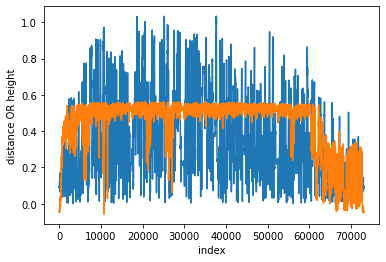

In [311]:
# to check, if distance and height starting from the 0
plt.plot(centBee_dsit, label = "distance")
plt.plot(beeHeight, label = "height")
plt.xlabel("index")
plt.ylabel("distance OR height")

In [312]:
len(centBee_dsit)

73011

In [313]:
z_coord = traj_nv.z
z_coord

0       -0.045768
1       -0.044862
2       -0.044765
3       -0.044030
4       -0.045372
           ...   
73006   -0.045844
73007   -0.045682
73008   -0.046146
73009   -0.045891
73010   -0.046356
Name: z, Length: 73011, dtype: float64

### Divide trajectory into in, mid and out sections

In [124]:
# #### -----------------Changed..Added the height also in selection criteria _____________________________######

# We want to seperate the sections of the trajectory in respective section lists. 
# The seperation of the trajectory will be based on the defined thresholds

# Define the threshold/s
threshold_1 = 0.05 # less that the radius of the clutter 
threshold_2 = 0.05 # More than the radius of the clutter

# lists for indices
traj_sec_1_index = list() # respective "Index position" list
traj_sec_2_index = list() # respective "Index position" list
traj_sec_3_index = list() # respective "Index position" list

# Temprory lists, the lists will get empty in if loop.  
aa_index = list()
bb_index = list()
cc_index = list()

ii = 0
while (ii<len(centBee_dsit)):
    # to get one continuous section of the trajectory, based on the defined thresholds
    
# ---------------------------------------------------------------------------------------------------------------
# inside clutter
# two condition, 1. distance and 2.height 
    while  (centBee_dsit[ii] <= (clut_radius-threshold_1) and (z_coord[ii] <= (clut_height-threshold_1))): 
        # bellow the threshold
        
        aa_index.append(ii)
        ii = ii+1
        if not (ii<len(centBee_dsit)):
            break
    if not (ii<len(centBee_dsit)):
        break    

# ---------------------------------------------------------------------------------------------------------------
# Between thresholds
# Two condition
    
    # condition 1 - middle part
    while ((centBee_dsit[ii] > (clut_radius-threshold_1)) and (centBee_dsit[ii] <= (clut_radius+threshold_2)) and (z_coord[ii] <= (clut_height+threshold_2))):
        # between the threshold and hegit must less than the clutter
        bb_index.append(ii)
        ii = ii+1
        if not (ii<len(centBee_dsit)):
            break
    if not (ii<len(centBee_dsit)):
        break  
    
    # condition 2 - middle part
    while ((z_coord[ii]> (clut_height-threshold_1)) and (z_coord[ii] <= (clut_height+threshold_2)) and 
           (centBee_dsit[ii]<(clut_radius-threshold_1))):
        bb_index.append(ii)
        ii = ii+1
        if not (ii<len(centBee_dsit)):
            break
    if not (ii<len(centBee_dsit)):
        break  

# ---------------------------------------------------------------------------------------------------------------
# outside the clutter
# Two conditions

    # condition 1 - dsitans based
    while (centBee_dsit[ii] > (clut_radius+threshold_2)): # beyond the threshold
        cc_index.append(ii)
        ii = ii+1
        if not (ii<len(centBee_dsit)):
            break
    if not (ii<len(centBee_dsit)):
        break
    # condition 2 -height based
    while (centBee_dsit[ii] < (clut_radius+threshold_2) and z_coord[ii] > (clut_height+threshold_2)):
        cc_index.append(ii)
        ii = ii+1
        if not (ii<len(centBee_dsit)):
            break
    if not (ii<len(centBee_dsit)):
        break
        
# ---------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------
                
    # function to append the list in the list
    if len(aa_index) != 0: # if "aa" is not empty
        traj_sec_1_index.append(aa_index)
        aa_index = list() # empying the list for next loop

    if len(bb_index) != 0: # if "bb" is not empty
        traj_sec_2_index.append(bb_index)
        bb_index = list()
    
    if len(cc_index) != 0: # if "cc" is not empty
        traj_sec_3_index.append(cc_index)
        cc_index = list()
        
if len(aa_index) != 0: # if "aa" is not empty
    traj_sec_1_index.append(aa_index)
    aa_index = list() # empying the list for next loop
    
if len(bb_index) != 0: # if "bb" is not empty
    traj_sec_2_index.append(bb_index)
    bb_index = list()
    
if len(cc_index) != 0: # if "cc" is not empty
    traj_sec_3_index.append(cc_index)
    cc_index = list()

In [66]:
print(len(traj_sec_1_index))
print(len(traj_sec_2_index))
print(len(traj_sec_3_index))

22
81
137


In [67]:
traj_sec_2_index

[[806, 807, 808, 809, 810, 811, 812, 813, 814, 815],
 [830],
 [832,
  833,
  834,
  835,
  836,
  837,
  838,
  839,
  840,
  841,
  842,
  843,
  844,
  845,
  846,
  847,
  848,
  849,
  850,
  851,
  852,
  853,
  854,
  855,
  856,
  857,
  858,
  859,
  860,
  861,
  862,
  863,
  864,
  865,
  866,
  867,
  868,
  869],
 [876],
 [899,
  900,
  901,
  902,
  903,
  904,
  905,
  906,
  907,
  908,
  909,
  910,
  911,
  912,
  913,
  914,
  915,
  916,
  917,
  918,
  919,
  920],
 [978],
 [980,
  981,
  982,
  983,
  984,
  985,
  986,
  987,
  988,
  989,
  990,
  991,
  992,
  993,
  994,
  995,
  996,
  997,
  998,
  999,
  1000,
  1001,
  1002,
  1003,
  1004,
  1005,
  1006,
  1007,
  1008,
  1009,
  1010,
  1011,
  1012,
  1013,
  1014,
  1015,
  1016,
  1017,
  1018],
 [1409, 1410, 1411],
 [1474,
  1475,
  1476,
  1477,
  1478,
  1479,
  1480,
  1481,
  1482,
  1483,
  1484,
  1485,
  1486,
  1487,
  1488,
  1489,
  1490,
  1491,
  1492],
 [1592],
 [5616, 5617, 5618, 5619]

In [68]:
# getting the list of 1.initial item 2.last item and 3.location (in, mid OR out)
sec1_idx_loc = [] # for in
sec2_idx_loc = [] # for mid
sec3_idx_loc = [] # for out
for hh in traj_sec_1_index: 
    start_end_idx1 = [hh[0]]+[hh[-1]]+['in'] # [start_idx, last_idx, 'in']
    sec1_idx_loc.append(start_end_idx1)
for ii in (traj_sec_2_index):
    start_end_idx2 = [ii[0]]+[ii[-1]]+['mid'] # [start_idx, last_idx, 'mid']
    sec2_idx_loc.append(start_end_idx2)
for jj in (traj_sec_3_index):
    start_end_idx3 = [jj[0]]+[jj[-1]]+['out'] # [start_idx, last_idx, 'out']
    sec3_idx_loc.append(start_end_idx3)

In [69]:
# check the lists
print(sec1_idx_loc[0:5])
print(sec2_idx_loc[0:5])
print(sec3_idx_loc[0:5])

[[0, 805, 'in'], [816, 829, 'in'], [831, 831, 'in'], [870, 875, 'in'], [877, 898, 'in']]
[[806, 815, 'mid'], [830, 830, 'mid'], [832, 869, 'mid'], [876, 876, 'mid'], [899, 920, 'mid']]
[[921, 977, 'out'], [979, 979, 'out'], [1019, 1408, 'out'], [1493, 1591, 'out'], [1593, 1731, 'out']]


In [70]:
#combine list to dataframe
idx_loc_df = pd.DataFrame(list((sec1_idx_loc + sec2_idx_loc + sec3_idx_loc)), columns=['start_idx','end_idx','position'])

In [71]:
idx_loc_df.head()

,start_idx,end_idx,position
0,0,805,in
1,816,829,in
2,831,831,in
3,870,875,in
4,877,898,in


In [72]:
# sort the dataframe based on the initial index, increasing order
idx_loc_df = idx_loc_df.sort_values(by='start_idx')

In [73]:
idx_loc_df.head() # index location data frame

,start_idx,end_idx,position
0,0,805,in
22,806,815,mid
1,816,829,in
23,830,830,mid
2,831,831,in


In [74]:
# indexing based on the flight direction ('in_mid_our' OR 'out_mid_in')

# Indexing for 'inmidout' direction

# for 'in_mid_out' direction
in_index1 = [] # 'in' location list
mid_index1 = [] # 'mid' location list
sub_mid_list = []
mid_list = []
out_index1 = [] # 'out' location list
# 1 indicated the direction 'inmidout'

for ii in range(len(idx_loc_df)): 
    
    if ii >= len(idx_loc_df):  
        break
    if (idx_loc_df.position.iloc[ii] == 'in'): # get the initial location
        
         # getting initial and last index and location
        u = [idx_loc_df.start_idx.iloc[ii],idx_loc_df.end_idx.iloc[ii],'in']
        jj = ii+1 # for while loop
        
        if jj >= len(idx_loc_df):
            break
        while idx_loc_df.position.iloc[jj] == 'mid': # there can be multiple 'mid', therefor while loop
            
            sub_mid_list = [idx_loc_df.start_idx.iloc[jj],idx_loc_df.end_idx.iloc[jj],'mid'] # intermediate 
            jj += 1    
        
        if len(sub_mid_list) != 0: # if the list is not empty
            v = [sub_mid_list[0],sub_mid_list[1],sub_mid_list[-1]]
        sub_mid_list = [] # for next while loop
        
        if idx_loc_df.position.iloc[jj] == 'out': # for 'out' direction
            w = [idx_loc_df.start_idx.iloc[jj],idx_loc_df.end_idx.iloc[jj],'out'] # out list
            key_str = u[-1]+v[-1]+w[-1] # string to compaire
            if (key_str == 'inmidout'): # to append the list
                u1 = [u[0],u[1],('{}'.format(key_str))]
                in_index1.append(u1)
                v2 = [v[0],v[1],('{}'.format(key_str))]
                mid_index1.append(v2)
                w2 = [w[0],w[1],('{}'.format(key_str))]
                out_index1.append(w2)
   


In [75]:
if len(in_index1) != 0 and len(mid_index1) != 0 and len(out_index1) != 0 :
    print(in_index1[0]) 
    print(mid_index1[0]) # first_index of mid_index1 should +1 (ex. 11) to end indext of in_index1 (ex.10)
    print(out_index1[0]) # first_index of out_index1 should +1 (ex. 21) to end indext of in_index1 (ex.20)

    

[877, 898, 'inmidout'] [899, 920, 'inmidout'] [921, 977, 'inmidout']


In [76]:
# Indexing for 'outmidin' direction

# for 'out_mid_in' direction
out_index2 = []

# for 'in_mid_out' direction
sub_mid_index = []
mid_index2 = []

in_index2 = []

for kk in range(len(idx_loc_df)):
    
    if kk >= len(idx_loc_df):  
        break
    if (idx_loc_df.position.iloc[kk] == 'out'): # 
        w = [idx_loc_df.start_idx.iloc[kk],idx_loc_df.end_idx.iloc[kk],'out'] 
        ll = kk+1
        
        if ll >= len(idx_loc_df):
            break
            
        while idx_loc_df.position.iloc[ll] == 'mid':
            sub_mid_list = [idx_loc_df.start_idx.iloc[ll],idx_loc_df.end_idx.iloc[ll],'mid']
            ll += 1
            
        if len(sub_mid_list) != 0:
            v = [sub_mid_list[0],sub_mid_list[1],sub_mid_list[-1]]
        sub_mid_list = []
          
        if idx_loc_df.position.iloc[ll] == 'in':
            u = [idx_loc_df.start_idx.iloc[ll],idx_loc_df.end_idx.iloc[ll],'in'] 
            key_str = w[-1]+v[-1]+u[-1] 
            if (key_str == 'outmidin'):
                u1 = [u[0],u[1],('{}'.format(key_str))]
                in_index2.append(u1)
                v2 = [v[0],v[1],('{}'.format(key_str))]
                mid_index2.append(v2)
                w2 = [w[0],w[1],('{}'.format(key_str))]
                out_index2.append(w2)
   


In [35]:
# # convert the "in-mid-out" lists to dataframe...seperated because of header
header = pd.MultiIndex.from_product([['inmidout_in'],['start_idx','end_idx','direction']])
in_index1 = pd.DataFrame(in_index1,columns=header)
header = pd.MultiIndex.from_product([['inmidout_mid'],['start_idx','end_idx','direction']])
mid_index1 = pd.DataFrame(mid_index1,columns=header)
header = pd.MultiIndex.from_product([['inmidout_out'],['start_idx','end_idx','direction']])
out_index1 = pd.DataFrame(out_index1,columns=header)


In [36]:
# # for "out-mid-in"
header = pd.MultiIndex.from_product([['outmidin_in'],['start_idx','end_idx','direction']])
in_index2 = pd.DataFrame(in_index2,columns=header)
header = pd.MultiIndex.from_product([['outmidin_mid'],['start_idx','end_idx','direction']])
mid_index2 = pd.DataFrame(mid_index2,columns=header)
header = pd.MultiIndex.from_product([['outmidin_out'],['start_idx','end_idx','direction']])
out_index2 = pd.DataFrame(out_index2,columns=header)

### Updating traj_nv file

In [314]:
fps = 62.5
timeseries = pd.Series(data=traj_nv.index/fps, index=traj_nv.index)
# colors, sm = get_color_dataframe(timeseries)

In [315]:
recording

'20210417_161622'

In [316]:
# updating traj_nv file, need for next part
# Adding the bee_distance
if traj_nv.columns[-1] != 'timeseries':
    traj_nv['bee_distance'] = centBee_dsit
    traj_nv['timeseries'] = timeseries
    traj_nv.to_csv('{0}/traj_nv_{1}_test.csv'.format(recording_path,recording))

In [317]:
traj_nv.head()

,frame_i,x,y,z,w,bee_distance,timeseries
0,1292,0.032967,0.089456,-0.045768,3.662713e-17,0.095338,0.000
1,1297,0.031618,0.088962,-0.044862,3.744226e-17,0.094414,0.016
2,1302,0.031198,0.088670,-0.044765,3.788606e-17,0.093998,0.032
3,1304,0.031379,0.088206,-0.044030,3.850403e-17,0.093621,0.048
4,1307,0.031186,0.088798,-0.045372,3.771099e-17,0.094116,0.064


### calculating the exit and entry points

In [1138]:
# comming back to mid
import statistics

In [1139]:
# all mid selected inmidout
idx_mid_inmidout = list()
for ii in range(len(traj_sec_2_index)):
    for jj in range(len(mid_index1)):
        if ((traj_sec_2_index[ii][0]) == (mid_index1.inmidout_mid.start_idx.iloc[jj])):
            idx_mid_inmidout.append(traj_sec_2_index[ii])
# selected_mid_inmidout = pd.DataFrame(selected_mid_inmidout)

# selected all mid outmidin
idx_mid_outmidin = list()
for ii in range(len(traj_sec_2_index)):
    for jj in range(len(mid_index2)):
        if ((traj_sec_2_index[ii][0]) == (mid_index2.outmidin_mid.start_idx.iloc[jj])):
            idx_mid_outmidin.append(traj_sec_2_index[ii])
# selected_mid_outmidin = pd.DataFrame(selected_mid_outmidin)

In [1140]:
# function 

def get_mean_df(idx_list,trajcectory_df): # index_list (idx_mid_inmidout, idx_mid_outmidin), traj_nv
    """function to get the mean of x,y,z and time of bee position"""
    """index of mid positions and traj.nv are needed"""
    x_mean = list()
    y_mean = list()
    z_mean = list()
    timeseries_mean = list()
    
    for ii in (idx_list):
        x_coord = list()
        y_coord = list()
        z_coord = list()
        bee_dist = list()
        timeseries = list()
        
        for jj in ii:
            # getting the coordinates and time 
            x_coord.append(trajcectory_df.x[jj])
            y_coord.append(trajcectory_df.y[jj])
            z_coord.append(trajcectory_df.z[jj])
            bee_dist.append(trajcectory_df.bee_distance[jj])
            timeseries.append(trajcectory_df.timeseries[jj])
        # mean of the coordinates 
        x_mean.append(statistics.mean(x_coord))
        y_mean.append(statistics.mean(y_coord))
        z_mean.append(statistics.mean(z_coord))
        timeseries_mean.append(statistics.mean(timeseries))
    # converting lists of the means to dataframe   
    x_mean = pd.DataFrame(x_mean,columns=['x_mean'])
    y_mean = pd.DataFrame(y_mean,columns=['y_mean'])
    z_mean = pd.DataFrame(z_mean,columns=['z_mean'])
    timeseries_mean = pd.DataFrame(timeseries_mean,columns=['time_mean'])
    # connecting the dataframes - all the means in one data frame
    coord_time_mean = pd.concat([x_mean.reset_index(drop=True),
                                y_mean.reset_index(drop=True),
                                 z_mean.reset_index(drop=True),
                                 timeseries_mean.reset_index(drop=True)],
                               axis = 1)
    return(coord_time_mean)
    

In [1141]:
exitmid_mean_df = get_mean_df(idx_mid_inmidout,traj_nv)
entrymid_mean_df = get_mean_df(idx_mid_outmidin,traj_nv)

In [1142]:
exitmid_mean_df.head()

,x_mean,y_mean,z_mean,time_mean
0,-0.183228,-0.248698,0.290136,5.648
1,-0.128695,0.222592,0.264101,7.776
2,-0.399311,0.016894,0.223120,37.264
3,-0.291917,-0.219970,0.001300,62.976


In [1143]:
entrymid_mean_df.head()

,x_mean,y_mean,z_mean,time_mean
0,-0.048503,-0.261503,0.265123,4.264
1,-0.219321,-0.002002,0.282017,6.816
2,-0.195302,0.037224,0.289166,8.552
3,0.157068,-0.332056,0.276753,43.184
4,-0.378277,-0.003257,-0.008251,64.024


In [1144]:

check_exitmean_csv = os.path.exists(os.path.join(recording_path,'/exitmid_mean_df_{}.csv'.format(recording)))
if not check_exitmean_csv: # if traj_nv file is not exists in the folder
    exitmid_mean_df.to_csv('{0}/exitmid_mean_df_{1}.csv'.format(recording_path,recording))


check_entrymean_csv = os.path.exists(os.path.join(recording_path,'/entrymid_mean_df_{}.csv'.format(recording)))
if not check_entrymean_csv:
    entrymid_mean_df.to_csv('{0}/entrymid_mean_df_{1}.csv'.format(recording_path,recording))